In [1]:
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import LineString, Point, Polygon, MultiLineString
import osmnx as ox

In [2]:
# define and run overpass query

overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = """
[out:json];
area["name"="Jaipur Municipal Corporation"]["boundary"="administrative"]->.searchArea;
(
  relation["type"="route"]["route"="bus"](area.searchArea);
);
out body;
>;
out skel qt;
"""

# Send the POST request
response = requests.post(overpass_url, data={'data': overpass_query})

# Raise error if request failed
response.raise_for_status()

# Parse response as JSON
data = response.json()

In [6]:
# -----------------
# Print the number of bus route relations found
relations = [el for el in data['elements'] if el['type'] == 'relation']
print(f"Found {len(relations)} bus route relations.")

# Print details about the first route
if relations:
    first = relations[0]
    print("Example bus route:")
    print("ID:", first.get('id'))
    print("Tags:", first.get('tags', {}))

Found 38 bus route relations.
Example bus route:
ID: 10300811
Tags: {'from': 'Khirni Phatak', 'interval': '00:20', 'name': 'Bus 7: Khirni Fatak - Transport Nagar', 'opening_hours': 'Mo-Su 08:00-21:00', 'operator': 'JCTSL', 'public_transport': '2', 'ref': '7', 'roundtrip': 'no', 'route': 'bus', 'to': 'Transport Nagar', 'type': 'route'}


In [8]:
# -----------------
# create objects for mapping
nodes = {el['id']: el for el in data['elements'] if el['type'] == 'node'}
ways = {el['id']: el for el in data['elements'] if el['type'] == 'way'}

# For each relation, collect its geometry and ref/name
route_geoms = []
route_labels = []
route_operator = []
route_interval = []

for rel in relations:
    # Get route number (ref) or fall back to 'name'
    ref = rel.get('tags', {}).get('ref') or rel.get('tags', {}).get('name') or f"relation {rel['id']}"
    operator = rel.get('tags', {}).get('operator')
    interval = rel.get('tags', {}).get('interval')
    # Find member ways
    member_way_ids = [m['ref'] for m in rel['members'] if m['type'] == 'way']
    coords = []
    for wid in member_way_ids:
        way = ways.get(wid)
        if not way:
            continue
        line_coords = []
        for nid in way['nodes']:
            node = nodes.get(nid)
            if node:
                line_coords.append((node['lon'], node['lat']))
        if len(line_coords) > 1:
            coords.append(LineString(line_coords))
    if coords:
        # Combine into MultiLine if more than one segment, else just use the LineString
        geom = coords[0] if len(coords) == 1 else gpd.GeoSeries(coords).unary_union
        route_geoms.append(geom)
        route_labels.append(ref)
        route_operator.append(operator)
        route_interval.append(interval)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame({'route': route_labels, 'operator': route_operator, 'interval': route_interval, 'geometry': route_geoms}, crs="EPSG:4326")
gdf.sort_values('route', inplace=True)
gdf

,route,operator,interval,geometry
20,1,JCTSL,None,"MULTILINESTRING ((75.84887 26.91825, 75.84861 ..."
19,1,JCTSL,None,"MULTILINESTRING ((75.78808 27.04376, 75.78825 ..."
11,1 Mini/1,JCTSL,00:30,"MULTILINESTRING ((75.77035 26.99856, 75.77025 ..."
12,1 Mini/1,JCTSL,00:30,"MULTILINESTRING ((75.76888 27.02900, 75.76893 ..."
29,11,JCTSL,None,"MULTILINESTRING ((75.89883 26.77621, 75.89991 ..."
30,11,JCTSL,None,"MULTILINESTRING ((75.81693 26.91532, 75.81672 ..."
1,14,JCTSL,00:30,"MULTILINESTRING ((75.77318 26.94013, 75.77276 ..."
3,14,JCTSL,00:30,"MULTILINESTRING ((75.77212 26.94051, 75.77228 ..."
26,1A,JCTSL,None,"MULTILINESTRING ((75.84406 26.90382, 75.84405 ..."
25,1A,JCTSL,None,"MULTILINESTRING ((75.79532 26.99786, 75.79511 ..."


In [13]:
# remove long distance routes 
gdf = gdf.query('route != "Jaipur To Bharatpur (RSRTC Express)"')

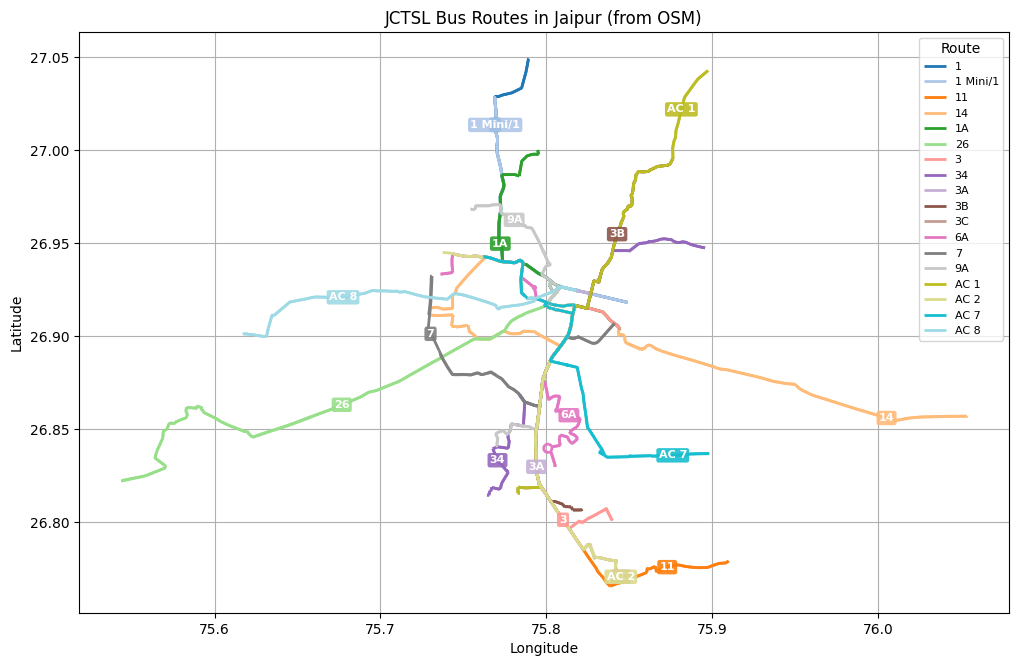

In [17]:
# -----------------
# Plot and label 1

# 1. Get unique routes and assign each a color
unique_routes = gdf['route'].unique()
cmap = plt.get_cmap('tab20', len(unique_routes))
route_to_color = {route: cmap(i) for i, route in enumerate(unique_routes)}

# 2. Plot, assigning color by 'route'
fig, ax = plt.subplots(figsize=(12, 8))

for route, group in gdf.groupby('route'):
    group.plot(ax=ax, color=route_to_color[route], linewidth=2, label=route)

    # For labeling: use the centroid or a representative point
    # If MultiLineString, use the largest geometry; otherwise, use the geometry itself
    # For lines, the centroid may not be on the line, so interpolate a point along the line

    geom = group.geometry.unary_union
    label_point = None
    if geom.geom_type == 'MultiLineString':
        line = max(geom.geoms, key=lambda l: l.length)
        label_point = line.interpolate(0.5, normalized=True)
    elif geom.geom_type == 'LineString':
        label_point = geom.interpolate(0.5, normalized=True)
    elif geom.geom_type == 'Point':
        label_point = geom
    else:
        label_point = geom.centroid # fallback to centroid


    # Add the label
    ax.text(
        label_point.x, label_point.y, str(route),
        fontsize=8, color='white', weight='bold',
        ha='center', va='center',
        bbox=dict(facecolor=route_to_color[route], edgecolor='none', boxstyle='round,pad=0.2', alpha=0.9)
    )


plt.title('JCTSL Bus Routes in Jaipur (from OSM)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title="Route", loc='upper right', fontsize=8)
plt.grid(True)
plt.show()

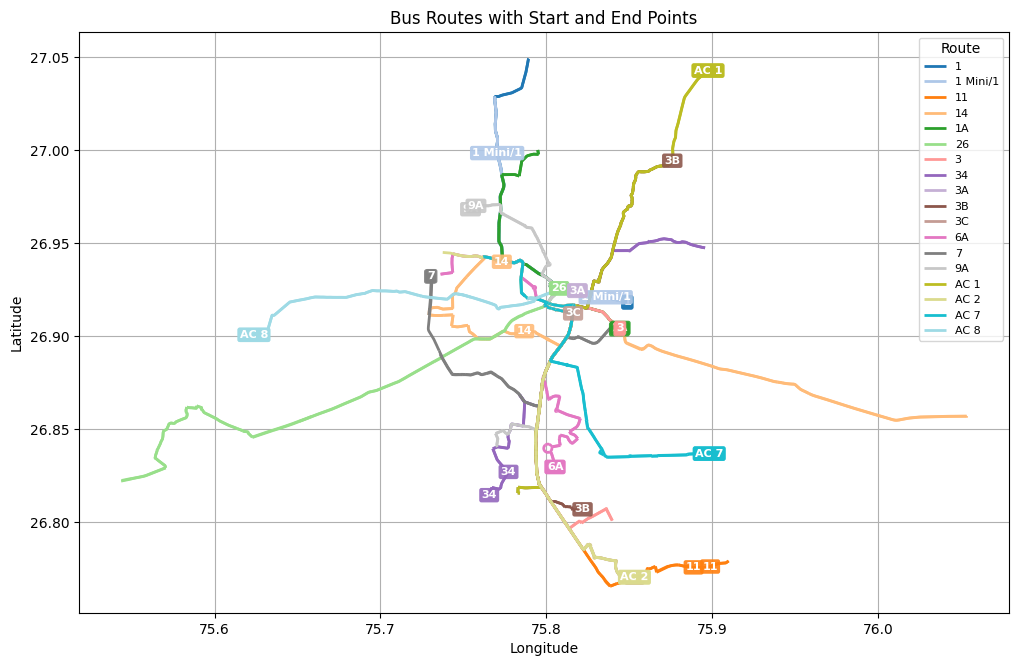

In [35]:
# -----------------
# Plot and label 2 - attempt to put route labels at beginning/end of each route

# Function to get start and end point from geometry
def get_start_end_points(geom):
    if geom.geom_type == 'MultiLineString':
        lines = list(geom.geoms)
        start_pt = lines[0].coords[0] if lines else None
        end_pt = lines[-1].coords[-1] if lines else None
    elif geom.geom_type == 'LineString':
        start_pt = geom.coords[0]
        end_pt = geom.coords[-1]
    elif geom.geom_type == 'Point':
        start_pt = end_pt = geom.coords[0]
    else:
        start_pt = end_pt = None  # For other types, return None

    return start_pt, end_pt

fig, ax = plt.subplots(figsize=(12, 8))

for route, group in gdf.groupby('route'):
    group.plot(ax=ax, color=route_to_color[route], linewidth=2, label=route)
    geom = group.geometry.unary_union
    start_pt, end_pt = get_start_end_points(geom)

    # Plot and label the start point
    if start_pt:
        ax.text(
            start_pt[0], start_pt[1], route,
            fontsize=8, color='white', weight='bold',
            ha='center', va='center',
            bbox=dict(facecolor=route_to_color[route], edgecolor='none', boxstyle='round,pad=0.2', alpha=0.9)
        )
    # Plot and label the end point
    if end_pt:
        ax.text(
            end_pt[0], end_pt[1], route,
            fontsize=8, color='white', weight='bold',
            ha='center', va='center',
            bbox=dict(facecolor=route_to_color[route], edgecolor='none', boxstyle='round,pad=0.2', alpha=0.9)
        )


plt.title('Bus Routes with Start and End Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title="Route", loc='best', fontsize=8)
plt.grid(True)
plt.show()


In [ ]:
gdf.explore(
           tooltip=['route', 'operator', 'interval'],  
              zoom_start=12,
                tiles='CartoDB positron',
                name='Bus Routes')


In [ ]:
# get bus stops using OSMNX

place_name = "Jaipur Municipal Corporation"
area = ox.geocode_to_gdf(place_name)

tags={'highway': 'bus_stop'} 

bus_stops = ox.features.features_from_place(place_name, tags)
bus_stops.plot()
